# Math 5680 Homework 2

## Problem 1.

Load the data.

In [185]:
import pandas
df = pandas.read_csv('Advertising.csv')

Construct the data matrix and label vector as a NumPy arrays.

In [186]:
import numpy as np
data_matrix = np.concatenate([np.ones((len(df), 1)), df[['TV', 'radio', 'newspaper']]], axis=1)
label_vector = df['sales']

Writing the normal equation $X^TX\theta = X^Ty$, where $X$ is the data matrix, and $y$ is the label vector, we see that solving the normal equation for $\theta$ is the same as solving $A\theta = b$, where $A = X^TX$, and $b = X^Ty$. In order to use a numerical solver for $A\theta = b$, then, we need to compute $A$ and $b$.

In [187]:
a_matrix = data_matrix.transpose() @ data_matrix
b_vector = data_matrix.transpose() @ label_vector

Now use `numpy.linalg.solve` to solve $A\theta = b$ numerically.

In [188]:
normal_theta = np.linalg.solve(a_matrix, b_vector)

Now let's calculate $\theta$ using Scikit-Learn and compare.

In [189]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(df[['TV', 'radio', 'newspaper']], label_vector)
sk_theta = np.concatenate([[model.intercept_], model.coef_])


Comparing the two $\theta$ values, we see that they are nearly the same, as expected.

In [190]:
print(f'Normal equations theta = {normal_theta}')
print(f'Scikit-Learn theta = {sk_theta}')
print(f'thetas are close? {np.allclose(normal_theta, sk_theta)}')

Normal equations theta = [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]
Scikit-Learn theta = [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]
thetas are close? True


## Problem 2.

Load the data (in case you don't have it already from Problem 1.).

In [191]:
import pandas
df = pandas.read_csv('Advertising.csv')
features = df[['TV', 'radio', 'newspaper']]
labels = df[['sales']]

### (1) Feature scaling

In [192]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(features)
scaled_features = scaler.transform(features)

### (2) Creating training and testing split

In [193]:
from sklearn.model_selection import train_test_split

test_features, train_features, test_labels, train_labels = train_test_split(
    scaled_features, labels,
    test_size=.8, train_size=.2, random_state=5680
)

### (3) Linear regression

Train a linear model on the training data.

In [194]:
from sklearn.linear_model import LinearRegression

# remember that TV, sales, newspaper are indices 1, 2, 3 and sales is index 4
linear_model = LinearRegression().fit(train_features, train_labels)

Now compute the $R^2$ scores on the training and testing data.

In [195]:
print(f'Training R^2 = {linear_model.score(train_features, train_labels):.04g}')
print(f'Testing R^2 = {linear_model.score(test_features, test_labels):.04g}')

Training R^2 = 0.9005
Testing R^2 = 0.8744


After running these cells a few times, I noticed that the training $R^2$ is generally higher than the testing $R^2$ (but not always). I suspect that this is due to the fact that the model fits in part to the noise in the training data, which is independent of the noise in the testing data, leading to a poorer fit on the testing data than on the training data.

Running the regression on 1000 different training-testing splits reveals that around 77% of splits lead to a better training score than testing score on this dataset, and that the average training $R^2$ is greater than the average testing $R^2$, but only by a little.

In [196]:
def random_r2_scores(reg):
    # generate a random training and testing split and calculate R^2 on training and testing data
    test_x, train_x, test_y, train_y = train_test_split(features, labels, train_size=0.8, test_size=0.2)
    model = reg().fit(train_x, train_y)
    
    return model.score(train_x, train_y), model.score(test_x, test_y)

scores = np.array([random_r2_scores(LinearRegression) for _ in range(1000)])
print(f'% training R^2 > testing R^2 {100 * np.mean(scores[:, 0] > scores[:, 1])}')
print(f'Average training R^2 = {np.mean(scores[:, 0]):.04g}')
print(f'Average testing R^2 = {np.mean(scores[:, 1]):.04g}')

% training R^2 > testing R^2 75.9
Average training R^2 = 0.9046
Average testing R^2 = 0.878


### (4) Ridge regression

Fit a ridge regression model to the same training and testing split from before.

In [197]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.).fit(train_features, train_labels)

Compare $R^2$ scores for training and testing data.

In [198]:
print(f'Training R^2 = {ridge_model.score(train_features, train_labels):.04g}')
print(f'Testing R^2 = {ridge_model.score(test_features, test_labels):.04g}')

Training R^2 = 0.8968
Testing R^2 = 0.877


The training $R^2$ is still higher for this split. Let's see how they compare for different values of $\alpha$.

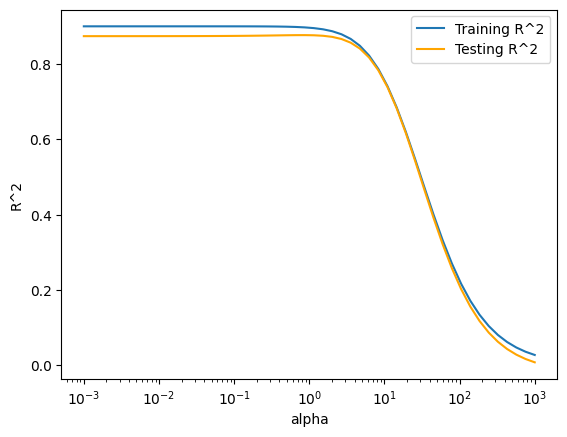

In [199]:
import matplotlib.pyplot as plt

alphas = np.logspace(-3, 3, 50)
train_r2s, test_r2s = [], []
for alpha in alphas:
    ridge_model_alpha = Ridge(alpha=alpha).fit(train_features, train_labels)
    
    train_r2s.append(ridge_model_alpha.score(train_features, train_labels))
    test_r2s.append(ridge_model_alpha.score(test_features, test_labels))

_, ax = plt.subplots()

ax.plot(alphas, train_r2s, label='Training R^2')
ax.plot(alphas, test_r2s, label='Testing R^2', c='orange')

ax.set_xlabel('alpha')
ax.set_ylabel('R^2')
ax.set_xscale('log')
ax.legend()

plt.show()

Evidently, the testing data $R^2$ is always lower, but the gap varies as $\alpha$ gets larger, initially decreasing almost to 0. The performance of the model in terms of $R^2$ also drops as $\alpha$ gets larger (because $\theta$ is being driven towards 0 as $\alpha \to \infty$).

Zooming in on the testing $R^2$ values, we see that the best value of $\alpha$ is around 0.85.

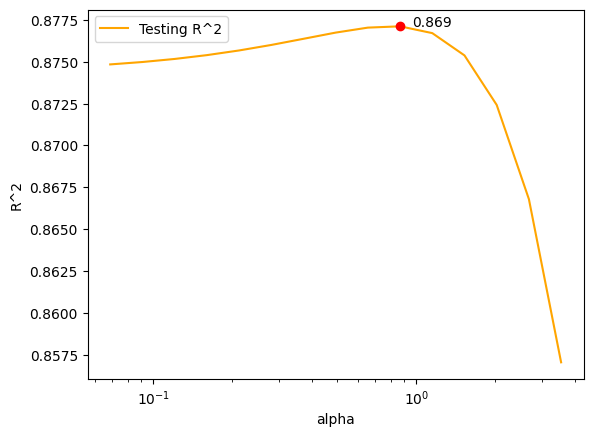

Best alpha = 0.8685, R^2 = 0.8771


In [200]:
i_best_alpha = np.argmax(test_r2s)
best_alpha = alphas[np.argmax(test_r2s)]

_, ax = plt.subplots()

ax.plot(alphas[15:30], test_r2s[15:30], label='Testing R^2', c='orange', zorder=0)
ax.scatter([best_alpha], [test_r2s[i_best_alpha]], c='red', zorder=1)
ax.annotate(f'{best_alpha:.03g}', [best_alpha + .1, test_r2s[i_best_alpha]])
ax.set_xlabel('alpha')
ax.set_ylabel('R^2')
ax.set_xscale('log')
ax.legend()

plt.show()

print(f'Best alpha = {best_alpha:.04g}, R^2 = {test_r2s[i_best_alpha]:.04g}')

This is actually *slightly* better than the $R^2$ obtained using the linear regression without regularization. Let's run 1000 regressions with this $\alpha$ and see how often the testing data $R^2$ is better than the training data $R^2$, and what the average $R^2$ values are.

In [201]:
scores = np.array([random_r2_scores(lambda: Ridge(alpha=best_alpha)) for _ in range(1000)])
print(f'% training R^2 > testing R^2 {100 * np.mean(scores[:, 0] > scores[:, 1])}')
print(f'Average training R^2 = {np.mean(scores[:, 0]):.04g}')
print(f'Average testing R^2 = {np.mean(scores[:, 1]):.04g}')

% training R^2 > testing R^2 78.5
Average training R^2 = 0.9069
Average testing R^2 = 0.8774


It looks not much different from the linear regression case.

### (5) Lasso regression

Fit a Lasso regression model to the same training and testing split from before.

In [202]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=1.).fit(train_features, train_labels)

Compare $R^2$ scores for training and testing data.

In [203]:
print(f'Training R^2 = {lasso_model.score(train_features, train_labels):.04g}')
print(f'Testing R^2 = {lasso_model.score(test_features, test_labels):.04g}')

Training R^2 = 0.2021
Testing R^2 = 0.2132


The $R^2$ scores are much lower than before, but the testing $R^2$ is actually a little higher than the training $R^2$. Let's look at the learned coefficients.

In [204]:
lasso_model.coef_

array([2.61420926, 0.        , 0.        ])

All but one coefficients are 0, so the Lasso model selected the most important features, as expected. If we run the regression and compute $R^2$ scores for many values of $\alpha$, we see that the $R^2$ scores are roughly independent of $\alpha$ except for a sharp drop from scores similar to what we had in the case of linear regression down to very low scores, which occurs near $\alpha = 1$. We also see that the number of coefficients that are not close to zero decreases as $\alpha$ increases, dropping from 2 to zero also around $\alpha = 1$.

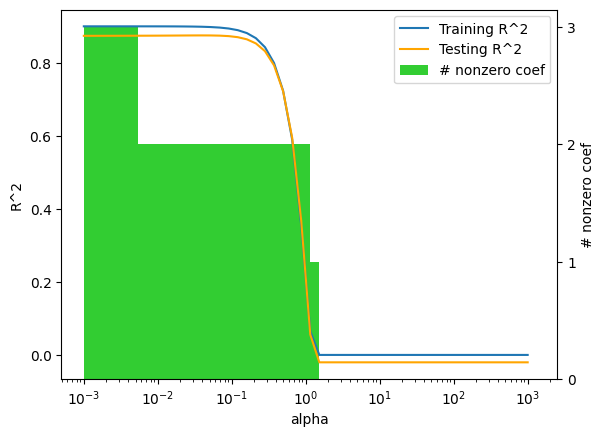

In [208]:
alphas = np.logspace(-3, 3, 50)
train_r2s, test_r2s, nonzero = [], [], []
for alpha in alphas:
    lasso_model_alpha = Lasso(alpha=alpha).fit(train_features, train_labels)
    
    train_r2s.append(lasso_model_alpha.score(train_features, train_labels))
    test_r2s.append(lasso_model_alpha.score(test_features, test_labels))
    nonzero.append(np.count_nonzero(np.bitwise_not(np.isclose(lasso_model_alpha.coef_, 0))))

_, ax = plt.subplots()

ax.plot(alphas, train_r2s, label='Training R^2')
ax.plot(alphas, test_r2s, label='Testing R^2', c='orange')

ax.set_xlabel('alpha')
ax.set_ylabel('R^2')
ax.set_xscale('log')

ax_nonzero = ax.twinx()
width = np.diff(alphas)
width = np.concatenate([width, [width[-1]]])
ax_nonzero.bar(alphas, nonzero, width=width, align='edge', facecolor='limegreen', label='# nonzero coef')
ax_nonzero.set_yticks([0, 1, 2, 3])
ax_nonzero.set_ylabel('# nonzero coef')

ax.set_zorder(ax_nonzero.get_zorder() + 1)
ax.set_frame_on(False)

ax_objs, ax_labels = ax.get_legend_handles_labels()
ax_nz_objs, ax_nz_labels = ax_nonzero.get_legend_handles_labels()
ax_nonzero.legend(ax_objs + ax_nz_objs, ax_labels + ax_nz_labels)

plt.show()